In [1]:
# NOTE: To run the experiments for the regular HGF you must have to kill Julia first (this happens due to compatibility issues)
# Then start running the code from this block
using ForneyLab
include("gcv/GCV.jl")
using Main.GCV
using CSV
using DataFrames
using Plots
using StatsPlots
using ProgressMeter
include("compatibility.jl")

# Auxialry function for graph initializtion
pad(sym::Symbol, t::Int) = sym*:_*Symbol(lpad(t,3,'0')) # Left-pads a number with zeros, converts it to symbol and appends to sym

pad (generic function with 1 method)

In [2]:
# required data
using CSV, DataFrames
df = CSV.File("data/AAPL.csv") |> DataFrame
series = df[!, :Open];

### 2-L HGF

In [3]:
# Auxialry function for graph initializtion
pad(sym::Symbol, t::Int) = sym*:_*Symbol(lpad(t,3,'0')) # Left-pads a number with zeros, converts it to symbol and appends to sym

pad (generic function with 1 method)

In [4]:
using CSV, DataFrames
df = CSV.File("data/AAPL.csv") |> DataFrame
series = df[!, :Open];

In [2]:
using ForneyLab
using ProgressMeter

# Function for generating 2-L HGF and message-passing (MP) algorithm
function generate_mp(n_samples)
    fg = FactorGraph()
    z = Vector{Variable}(undef, n_samples)
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)

    @RV ω ~ GaussianMeanPrecision(placeholder(:mω), placeholder(:wω))
    @RV [id=pad(:z,1)] z[1] ~ GaussianMeanPrecision(placeholder(:mz_prior1), placeholder(:wz_prior1))
    @RV [id=pad(:x,1)] x[1] ~ GaussianMeanPrecision(placeholder(:mx_prior1), placeholder(:wx_prior1))
    @RV [id=pad(:y,1)] y[1] ~ GaussianMeanPrecision(x[1], placeholder(:wy_prior1))
    placeholder(y[1], :y, index = 1)
    for t in 2:n_samples
        @RV [id=pad(:z,t)] z[t] ~ GaussianMeanPrecision(z[t - 1], placeholder(pad(:wz_transition, t)))
        @RV [id=pad(:x,t)] x[t] ~ GaussianControlledVariance(x[t - 1], z[t], 1.0, ω)
        @RV [id=pad(:y,t)] y[t] ~ GaussianMeanPrecision(x[t], placeholder(pad(:wy_transition, t)))
        placeholder(y[t], :y, index = t)
    end
    q = PosteriorFactorization(x, z, ω, ids=[:X :Z :Ω])
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true);
    return src_code
end

# Function for running MP-based inference for 2-L HGF
function mp(obs;
    n_its = 100,
    wy_prior1 = 1.0,
    ω_m_prior = omega,
    ω_w_prior = 1.0,
    z_m_prior = 0.0,
    z_w_prior = 100.0,
    x_m_prior = 0.0,
    x_w_prior = 1.0,
    x_x_m_prior = zeros(2),
    x_x_w_prior = 1.0*diageye(2),
    z_z_m_prior = zeros(2),
    z_z_w_prior = 100.0*diageye(2),
    z_w_transition_prior = 1000.0,
    y_w_transition_prior =  1/mnv,
)
    n_samples = length(obs)
    marginals = Dict()
    marginals[:ω] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = ω_m_prior, w = ω_w_prior)
    marginals[pad(:z,1)] = vague(GaussianMeanPrecision)
    marginals[pad(:x,1)] = vague(GaussianMeanPrecision)
    for t = 2:n_samples
        marginals[pad(:z,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = z_m_prior, w = z_w_prior)
        marginals[pad(:x,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = x_m_prior, w = x_w_prior)
        marginals[pad(:z,t)*:_*pad(:z,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = z_z_m_prior, w = z_z_w_prior)
        marginals[pad(:x,t)*:_*pad(:x,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = x_x_m_prior, w = x_x_w_prior)
    end
    data = Dict()
    data[:y] = obs
    data[:mz_prior1] = z_m_prior
    data[:wz_prior1] = z_w_prior
    data[:mx_prior1] = x_m_prior
    data[:wx_prior1] = x_w_prior
    data[:wy_prior1] = wy_prior1
    data[:mω] = ω_m_prior
    data[:wω] = ω_w_prior
    for t = 1:n_samples
        data[pad(:wz_transition, t)] = z_w_transition_prior
        data[pad(:wy_transition, t)] = y_w_transition_prior
    end


    fe = Vector{Float64}(undef, n_its)

    @showprogress "Iterations" for i = 1:n_its

        stepX!(data, marginals)
        stepZ!(data, marginals)
        stepΩ!(data, marginals)

        fe[i] = freeEnergy(data, marginals)
    end

    mz = [ForneyLab.unsafeMean(marginals[pad(:z,t)]) for t=1:n_samples]
    vz = [ForneyLab.unsafeVar(marginals[pad(:z,t)]) for t=1:n_samples]
    mω = ForneyLab.unsafeMean(marginals[:ω])
    vω = ForneyLab.unsafeCov(marginals[:ω])
    mx = [ForneyLab.unsafeMean(marginals[pad(:x,t)]) for t=1:n_samples]
    vx = [ForneyLab.unsafeVar(marginals[pad(:x,t)]) for t=1:n_samples]
    return mz,vz,mω, vω, mx,vx,fe
end

LoadError: LoadError: UndefVarError: `@showprogress` not defined
in expression starting at c:\xampp\htdocs\SGCV\validation-part5.ipynb:71

In [6]:
omega  = 1.0
kappa = 1.0
src_code = generate_mp(length(series))
eval(Meta.parse(src_code));
mz0, vz0, mω0, vω0, mx0,vx0,fe0 = mp(series, x_m_prior=series[1], z_z_w_prior=100.0 * diageye(2), z_w_transition_prior=100.0, ω_m_prior=omega, ω_w_prior=1.0, y_w_transition_prior=1.0);

results =   Dict("mz" => mz0, "vz" => vz0,
                 "mx" => mx0, "vx" => vx0,
                 "fe" => fe0,
                 "mω" => mω0, "vω" => vω0,
                 "ωprior" => omega)

Iterations 100%|█████████████████████████████████████████| Time: 0:00:09


Dict{String, Any} with 8 entries:
  "vx"     => [0.416446, 0.540638, 0.545067, 0.540454, 0.535592, 0.530933, 0.52…
  "vω"     => 1.32846e-11
  "mz"     => [-0.0327504, -0.0655008, -0.0954151, -0.122481, -0.146818, -0.168…
  "mx"     => [65.8395, 66.4175, 66.4286, 66.4956, 66.3093, 65.3197, 65.5052, 6…
  "fe"     => [761.47, 736.074, 732.846, 731.36, 730.675, 730.398, 730.294, 730…
  "mω"     => 0.653036
  "vz"     => [0.00940281, 0.0176112, 0.0249062, 0.0313169, 0.0369435, 0.041862…
  "ωprior" => 1.0

In [7]:
using JLD
JLD.save("dump/results_hgf_stocks_mixture.jld", "results", results)

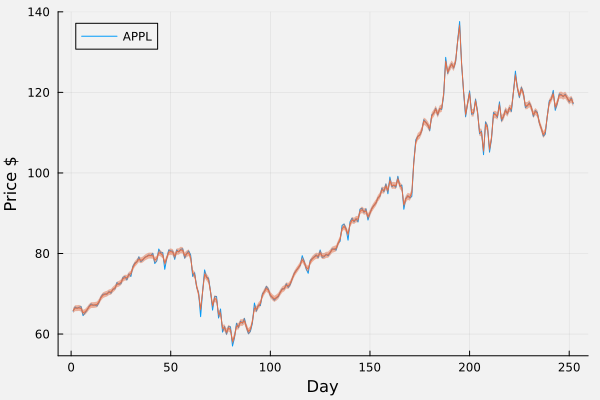

In [8]:
plot(series, background_color=:grey95, xlabel=:Day, ylabel="Price \$", label="APPL")
plot!(mx0, ribbon=sqrt.(vx0), label=false)

[ Info: Saved animation to /Users/jared/Downloads/SGCV/tmp.gif


Plots.AnimatedGif("/Users/jared/Downloads/SGCV/tmp.gif")
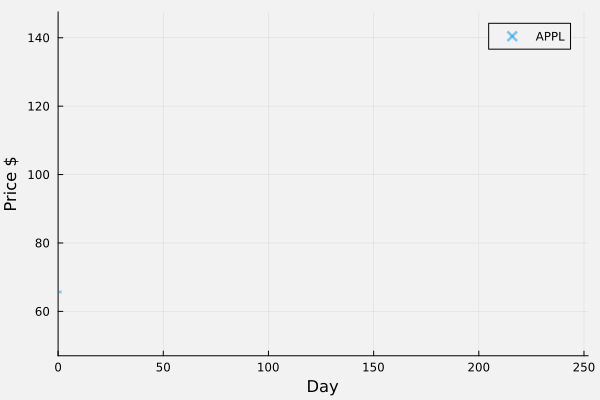

In [9]:
shift = 10
@gif for i in 1:length(series)
    scatter(series[1:i], markershape=:xcross, markersize=1.5, markeralpha=0.5, xlim = (0, length(series)), ylim = (minimum(series)-shift, maximum(series)+shift), label="APPL", xlabel=:Day, ylabel="Price \$", background_color=:grey95)
#     scatter(series[1:i], markershape=:xcross, markersize=1.5, markeralpha=0.5, xlim = (0, length(series)), ylim = (minimum(series)-shift, maximum(series)+shift), label=:APPL, xlabel=:Day, ylabel="Price \$", background_color=:grey95)
    plot!(mx0[1:i], ribbon=sqrt.(vx0[1:i]), label=false)
end every 1

[ Info: Saved animation to /Users/jared/Downloads/SGCV/tmp.gif


Plots.AnimatedGif("/Users/jared/Downloads/SGCV/tmp.gif")
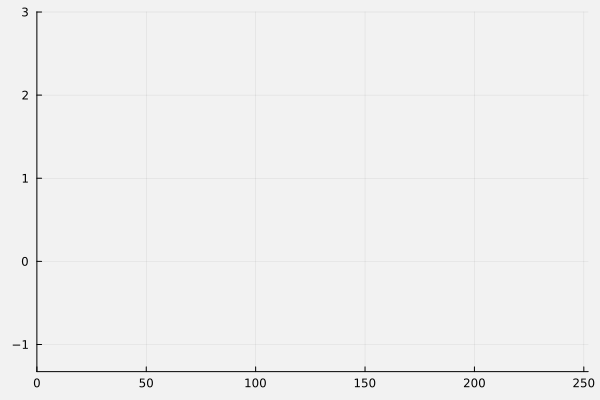

In [10]:
shift = 1
@gif for i in 1:length(series)
    plot(mz0[1:i], ribbon=sqrt.(vz0[1:i]), label=false, xlim = (0, length(series)), ylim = (minimum(mz0)-shift, maximum(mz0)+shift) ,background_color=:grey95)
end every 1